<h1> Finding a good de-noised image</h1>

<h3> Some properties of the full image</h3>

In [1]:
from utils.global_props import get_all_letters
background_x = 1200
background_y = 1200

alphabet_size = len(get_all_letters())

In [2]:
from PIL import Image
def load_base_image(letter):
    img = Image.open(f"base_images/{letter}.jpeg")
    return img


In [3]:
def make_de_noised_image(image:str, save_file_name="", verbose=False):
    all_letters = sorted(list(image))
    # Load images per letter
    all_letters_images = [load_base_image(l) for l in all_letters] 
    
    #Space between letters and border
    offset = 10
    new_letter_size = (background_x-offset*(alphabet_size+1))//alphabet_size
    # Resize the letter to fit the larger image
    all_letters_images = [image.resize([new_letter_size,new_letter_size]) for image in all_letters_images]
    
    background = Image.new('RGB',(background_x,background_y))

    x_offset_total = int(background_x // 2 - offset*1/2*(len(image)-1) - len(image)*new_letter_size/2)
    x_offset_each = offset + new_letter_size
    y_offset = int(background_y // 2 - new_letter_size // 2)
    
    curr_x = x_offset_total
    for letter_img in all_letters_images:
        background.paste(letter_img, [curr_x, y_offset])
        curr_x += x_offset_each
    if verbose:
        background.show()
    
    if save_file_name != "":
        background.save(f"base_images/simple_images/{save_file_name}.png")
    return background


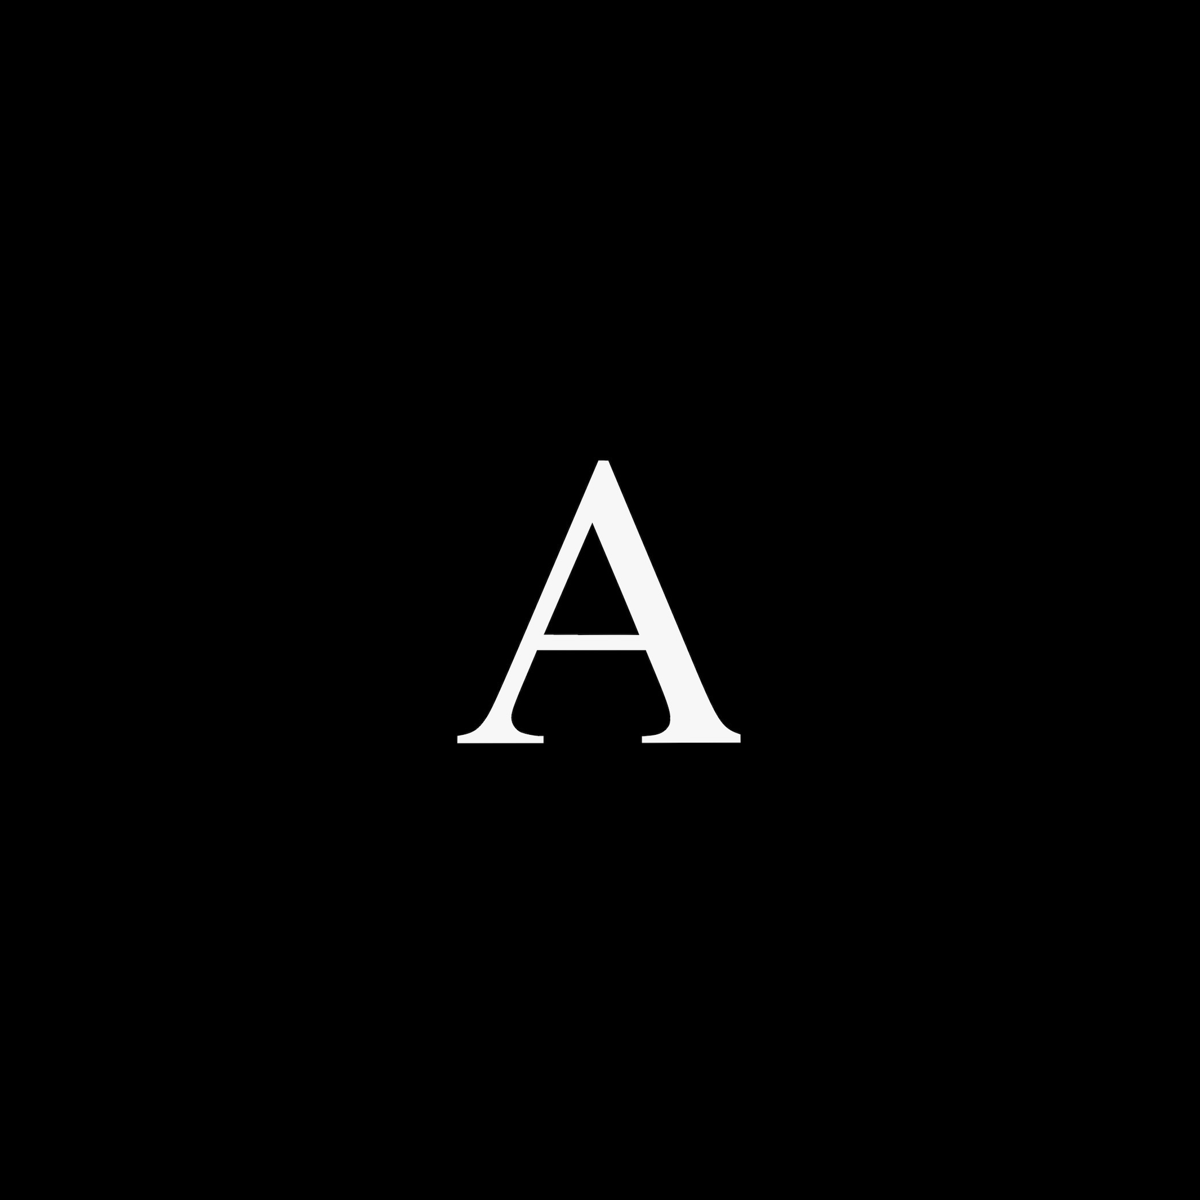

In [4]:
make_de_noised_image("A")

<h2> The above code can convert one image to a simplified version </h2>

In [5]:
from PIL import Image
def load_question_template():
    img = Image.open("base_images/base_question/question_template.png")    
    return img


In [6]:
def place_images_in_boxes(positive_images, negative_images):
    base = load_question_template()
    positive_top_left = [170,1770]
    positive_bottom_right = [2690,7350]
    
    negative_top_left = [2975,1770]
    negative_bottom_right = [5495,7350]
    
    # Size of lettergroup images
    w_l = 0
    h_l = 0
    if len(positive_images) > 0:
        w_l,h_l = positive_images[0].size
    elif len(negative_images) > 0:
        w_l,h_l = negative_images[0].size
    else:
        return base
    
    # Find offset such that space between images and edges are same
    
    # with of rectangle positive box
    X_b = positive_bottom_right[0] - positive_top_left[0]
    
    off_set = (X_b - 2*w_l)//3
    
        
    # positive examples
    curr_x = positive_top_left[0] + off_set
    curr_y = positive_top_left[1] + off_set
    for i,image in enumerate(positive_images):
        base.paste(image, [curr_x, curr_y])
        #base.show()
        
        w,h = image.size
        if i % 2==0:
            curr_x = curr_x + w + off_set
        else:
            curr_x = positive_top_left[0] + off_set
            curr_y = curr_y + h + off_set
        
    # negative examples
    curr_x = negative_top_left[0] + off_set
    curr_y = negative_top_left[1] + off_set
    for i,image in enumerate(negative_images):
        base.paste(image, [curr_x, curr_y])
        #base.show()
        
        w,h = image.size
        if i % 2==0:
            curr_x = curr_x + w + off_set
        else:
            curr_x = negative_top_left[0] + off_set
            curr_y = curr_y + h + off_set
    
    return base

In [7]:
from human_experiments.find_teachingset import get_images_matching_teaching_set as get_images
def generate_question_from_ts(teaching_set,ai,noise=True):
    if noise:
        positive_images = get_images([(l,v) for l,v in teaching_set if v],ai)
        negative_images = get_images([(l,v) for l,v in teaching_set if not v],ai)
    else:
        positive_images = [make_de_noised_image(l) for l,v in teaching_set if v]
        negative_images = [make_de_noised_image(l) for l,v in teaching_set if not v]
    
    # resize images
    positive_images = [img.resize([background_x,background_y]) for img in positive_images]
    negative_images = [img.resize([background_x,background_y]) for img in negative_images]
    print(len(negative_images))

    question = place_images_in_boxes(positive_images,negative_images)
    return question
    


In [8]:
def res_converter(result:str):
    labels,values = result.split(",")
    labels = labels.split("-")
    values = values.split("-")
    ts = []
    for label,value in zip(labels,values):
        ts.append((label,value=="1"))
    return ts

In [11]:
ts = res_converter("-A,1-0")

In [13]:
from models.trainModel import load_model
ai = load_model(f"Trails_class_nA100000")
generate_question_from_ts(ts,ai,noise=True)

1
